# TAOS1: clean ship data

**taos1-drifters0:** Missing data files for drifter recovery

**taos1-drifters1:** Manually concatenated `ship_delphy_30112022_a.csv` and `ship_delphy_30112022_a.csv`. Missing data files for drifter recovery

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos1/"

# taos1-drifters0
campaign="taos1_drifters0"
yaml = f"drifters0/{campaign}.yaml"
ships = ["hydrophone", "delphy"]

# taos1-drifters0
campaign="taos1_drifters1"
yaml = f"drifters1/{campaign}.yaml"
ships = ["delphy"]

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

d0 drifter0 None d0 / start 2022-05-11 05:10:00 -0.24 49.34 / end 2022-05-13 07:10:00 -0.01 49.36
d0 drifter1 None d0 / start 2022-05-11 05:40:00 -0.25 49.33 / end 2022-05-13 07:20:00 -0.04 49.35
d0 drifter2 None d0 / start 2022-05-11 05:50:00 -0.24 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
d0 drifter3 None d0 / start 2022-05-11 05:50:00 -0.24 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
d0 drifter4 None d0 / start 2022-05-11 05:50:00 -0.25 49.34 / end 2022-05-11 08:40:00 -0.25 49.34
d1 drifter4 None d1 / start 2022-05-11 09:20:00 -0.27 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
d0 drifter5 None d0 / start 2022-05-11 06:00:00 -0.24 49.35 / end 2022-05-11 06:20:00 -0.23 49.35
d1 drifter5 None d1 / start 2022-05-11 06:40:00 -0.23 49.35 / end 2022-05-13 08:00:00 -0.04 49.35
d0 delphy None d0 / start 2022-11-30 12:00:00 / end 2022-11-30 16:50:00


---

## ships


In [3]:
# search for deployments
s = ships[0]
deployments = list(cp[s]["deployments"])
print("Available deployments: "+" / ".join(deployments))

# select a deployment to process
d = deployments[0] # d0
#d = deployments[1] # d1
print(f"Working with deployment {d} here")

# need to manually set correct day
#cday = dict(year=2022, month=5, day=11)
cday = cp[s][d].start.time.round("1D").tz_localize("UTC")

# load data
D = dict()
for s in ships:
    file = os.path.join(cp["path_raw"], cp[s][d]["file"])
    D[s] = se.read_lern_ship(file, correct_day=cday)

Available deployments: d0
Working with deployment d0 here
columns:
['ï»¿ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']
Fix first time from 2022-11-30 11:44:44+00:00 to 2022-11-30 11:44:44+00:00


### plot

Find mission start end manually

In [4]:
s = "hydrophone"
if s in ships:
    D[s].geo.plot_bokeh(deployments=cp[s][d]) #
    D[s].geo.plot_bokeh_map()

In [5]:
s = "delphy"
if s in ships:
    D[s].geo.plot_bokeh(deployments=cp[s][d]) #
    D[s].geo.plot_bokeh_map()

Loading BokehJS ...

-0.463602477684617 -0.087458956986666
49.29384590126574 49.431311041116714


Loading BokehJS ...

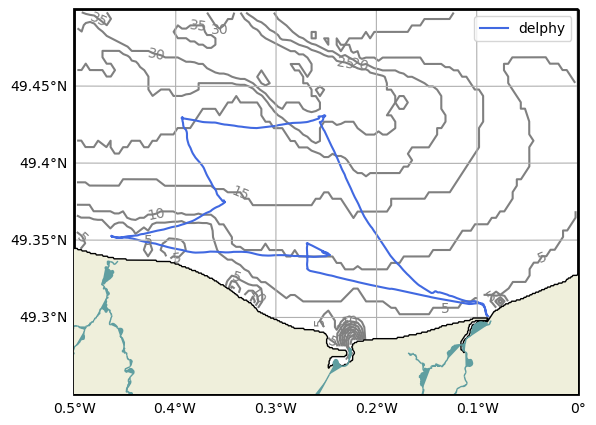

In [6]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-.5, .0, 49.25, 49.5]
fig, ax, cbar = cp.map(extent=bounds)

for s in ships:
    ax.plot(D[s].longitude, D[s].latitude, transform=crs, label=s, color=cp[s]["color"],)

ax.legend()

### Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 0, '[s]')

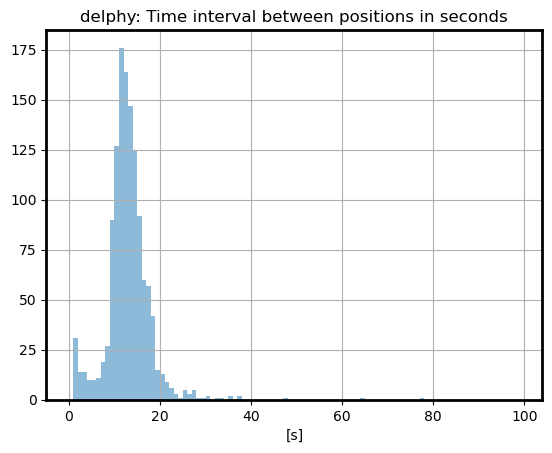

In [7]:

for s in ships:

    _df = D[s].reset_index()
    _df["dt"] = _df["time"].diff()/pd.Timedelta("1s")
    _df["dt"].hist(bins=np.arange(0,100,1), alpha=0.5)
    plt.title(s+": Time interval between positions in seconds")
plt.xlabel("[s]")

### store

In [9]:
for s in ships:
    (D[s].to_xarray()
     .to_netcdf(os.path.join(cp["path_processed"], f'{s}_{d}.nc'), mode="w")
    )